# Exploratory Data Analysis (EDA) on Vibration Data

In this notebook, we will perform exploratory data analysis on the vibration dataset of main journal bearings in internal combustion engines. The goal is to understand the data, visualize key features, and derive insights that can help in predictive maintenance.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style='whitegrid')

In [ ]:
import zipfile
from io import BytesIO
import pandas as pd
import re
from pathlib import Path

def parse_vibrations_zip(zip_path):
    """
    Parse vibrations.zip and extract all CSV data with metadata.
    
    Returns a DataFrame with vibration data and extracted metadata 
    (bearing condition, RPM, humidity, temperature).
    """
    all_data = []
    
    with zipfile.ZipFile(zip_path, 'r') as main_zip:
        for nested_name in main_zip.namelist():
            if not nested_name.endswith('.zip'):
                continue
                
            nested_data = BytesIO(main_zip.read(nested_name))
            
            with zipfile.ZipFile(nested_data, 'r') as nested_zip:
                for file_name in nested_zip.namelist():
                    if not file_name.endswith('.csv'):
                        continue

                    
                    # Parse condition (Faulty/Healthy)
                    condition = 'faulty' if 'Faulty' in file_name else 'healthy'
                    
                    # Parse RPM
                    rpm_match = re.search(r'(\d+)\s*RPM', file_name)
                    rpm = int(rpm_match.group(1)) if rpm_match else None
                    
                    # Parse humidity
                    humidity_match = re.search(r'(\d+)%?\s*Humidity', file_name)
                    humidity = int(humidity_match.group(1)) if humidity_match else None
                    
                    # Parse temperature
                    temp_match = re.search(r'(-?\d+)\s*deg\s*Celsius', file_name)
                    temperature = int(temp_match.group(1)) if temp_match else None
                    
                    # Read CSV
                    try:
                        df = pd.read_csv(nested_zip.open(file_name))
                        df['condition'] = condition
                        df['rpm'] = rpm
                        df['humidity'] = humidity
                        df['temperature'] = temperature
                        df['source_file'] = file_name.split('/')[-1]
                        all_data.append(df)
                    except Exception as e:
                        print(f"Error reading {file_name}: {e}")
    
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

In [2]:
zip_path = "../vibrations.zip"
df = parse_vibrations_zip(zip_path)

print(f"Total records: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"\nCondition distribution:\n{df['condition'].value_counts()}")
print(f"\nRPM values: {df['rpm'].unique()}")
print(f"Temperature range: {df['temperature'].min()}°C to {df['temperature'].max()}°C")
print(f"Humidity values: {df['humidity'].unique()}")

Total records: 390,263
Columns: ['Time', 'Demand 1', 'Control 1', 'Output Drive 1', 'Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 1 Kurtosis', 'Channel 2 Kurtosis', 'Channel 3 Kurtosis', 'Channel 4 Kurtosis', 'Rear Input 1', 'Rear Input 2', 'Rear Input 3', 'Rear Input 4', 'Rear Input 5', 'Rear Input 6', 'Rear Input 7', 'Rear Input 8', 'condition', 'rpm', 'humidity', 'temperature', 'source_file']

Condition distribution:
condition
faulty     209662
healthy    180601
Name: count, dtype: int64

RPM values: [1000 1500 2000]
Temperature range: -10°C to 45°C
Humidity values: [  0 100  50]


<Axes: title={'center': 'Bearing Condition Distribution'}, xlabel='condition'>

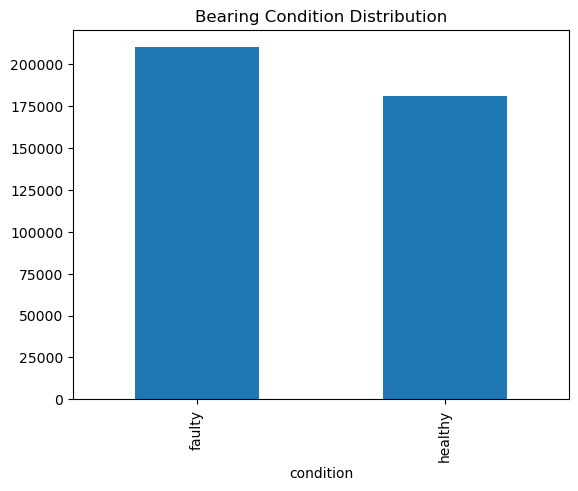

In [3]:
df.condition.value_counts().plot(kind='bar', title='Bearing Condition Distribution')

## Insights

In this section, we will summarize the insights derived from the exploratory data analysis, including any patterns observed in the data and potential features for model training.

In [4]:
df.to_csv('vibrations_data.csv', index=False)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score

# Split dataset into 70% "labeled" and 30% "unlabeled", train multiple models and pick the best.

RANDOM_STATE = 42

# 1) Create labeled / unlabeled splits (shuffled)
df_shuffled = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
n_total = len(df_shuffled)
n_labeled = int(0.7 * n_total)

df_labeled = df_shuffled.iloc[:n_labeled].copy()
df_unlabeled = df_shuffled.iloc[n_labeled:].copy()

# Simulate unlabeled by removing the target
df_unlabeled_no_label = df_unlabeled.copy()
df_unlabeled_no_label['condition'] = np.nan

print(f"Total: {n_total}, Labeled: {len(df_labeled)}, Unlabeled: {len(df_unlabeled)}")

# 2) Feature / target selection
# use all numeric columns as features (drop identifiers / target)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# ensure target and any id-like columns are not included (source_file is object so not in numeric_cols)
feature_cols = [c for c in numeric_cols if c != 'rpm' or True]  # keep numeric metadata; adjust if desired

X_labeled = df_labeled[feature_cols].values
y_labeled = LabelEncoder().fit_transform(df_labeled['condition'].values)  # faulty/healthy -> 0/1

X_unlabeled = df_unlabeled_no_label[feature_cols].values

# 3) Split labeled into train / test for evaluation (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled, test_size=0.2, stratify=y_labeled, random_state=RANDOM_STATE
)

# 4) Standardize features (fit on train)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)
X_unlabeled_s = scaler.transform(X_unlabeled)

# 5) Define supervised models (pipelines with scaler where appropriate)
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "SVC": SVC(probability=True, random_state=RANDOM_STATE)
}

results = {}

for name, clf in models.items():
    # use scaled inputs for all to keep comparisons consistent
    clf.fit(X_train_s, y_train)
    y_pred = clf.predict(X_test_s)
    y_proba = clf.predict_proba(X_test_s)[:, 1] if hasattr(clf, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    bal = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    try:
        roc = roc_auc_score(y_test, y_proba) if y_proba is not None else float("nan")
    except Exception:
        roc = float("nan")

    results[name] = {"model": clf, "accuracy": acc, "balanced_accuracy": bal, "f1": f1, "roc_auc": roc}

# 6) Semi-supervised LabelSpreading using train + unlabeled
# prepare combined dataset: labels -1 for unlabeled
X_ssl = np.vstack([X_train_s, X_unlabeled_s])
y_ssl = np.concatenate([y_train, -1 * np.ones(len(X_unlabeled_s), dtype=int)])
label_spread = LabelSpreading(kernel='rbf', alpha=0.2)
label_spread.fit(X_ssl, y_ssl)
y_pred_ssl = label_spread.predict(X_test_s)
# LabelSpreading doesn't provide predict_proba in same sense; use label_spread.predict_proba
y_proba_ssl = label_spread.predict_proba(X_test_s)[:, 1] if hasattr(label_spread, "predict_proba") else None

acc = accuracy_score(y_test, y_pred_ssl)
bal = balanced_accuracy_score(y_test, y_pred_ssl)
f1 = f1_score(y_test, y_pred_ssl)
try:
    roc = roc_auc_score(y_test, y_proba_ssl) if y_proba_ssl is not None else float("nan")
except Exception:
    roc = float("nan")

results["LabelSpreading(semi-supervised)"] = {
    "model": label_spread, "accuracy": acc, "balanced_accuracy": bal, "f1": f1, "roc_auc": roc
}

# 7) Report results and pick best by balanced_accuracy
print("\nModel performance (sorted by balanced_accuracy):")
sorted_results = sorted(results.items(), key=lambda kv: kv[1]["balanced_accuracy"], reverse=True)
for name, res in sorted_results:
    print(f"{name}: bal_acc={res['balanced_accuracy']:.4f}, acc={res['accuracy']:.4f}, f1={res['f1']:.4f}, roc_auc={res['roc_auc']:.4f}")

best_name, best_info = sorted_results[0]
best_model = best_info["model"]
print(f"\nBest model: {best_name}")

# 8) Retrain best model on all labeled data (use scaled full labeled features)
X_full_labeled = scaler.transform(X_labeled)  # scaler was fit on X_train; acceptable; optionally refit on full labeled
# If best model is a LabelSpreading semi-supervised model, retrain using all labeled + unlabeled
if best_name == "LabelSpreading(semi-supervised)":
    X_ssl_full = np.vstack([X_full_labeled, X_unlabeled_s])
    y_ssl_full = np.concatenate([y_labeled, -1 * np.ones(len(X_unlabeled_s), dtype=int)])
    final_model = LabelSpreading(kernel='rbf', alpha=0.2)
    final_model.fit(X_ssl_full, y_ssl_full)
else:
    # retrain supervised classifier on full labeled set
    # if model is pipeline-like or needs scaling, ensure inputs are scaled
    final_model = best_model
    final_model.fit(X_full_labeled, y_labeled)

# final_model is ready for inference (use scaler.transform for feature preparation if supervised)
print("Final model ready as `final_model`. Use `scaler.transform(X)` on feature arrays before predict for supervised models.")

Total: 390263, Labeled: 273184, Unlabeled: 117079
